In [25]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

## Data loading and processing

Description of the variables:

- the target variable “flow” in cubic meters per second at a single location <br>
- the predictor precipitation “obs_pr” in mm at 9 surrounding locations <br>
- the predictor temperature “obs_tas” in Celsius at 9 surrounding locations

In [26]:
#Load the data

path = '/home/germanm2/climateAI_assignment/uke_eggedal_data_challenge.pkl'

with open(path, 'rb') as f:
    data_dict = pickle.load(f)

In [3]:
#look at the keys
data_dict.keys()

dict_keys(['flow', 'obs_tas', 'flow_dates', 'obs_lon_lat', 'obs_pr', 'obs_dates'])

In [4]:
#look at the length of values
length_dict = {key: len(value) for key, value in data_dict.items()}
length_dict

{'flow': 21542,
 'obs_tas': 21546,
 'flow_dates': 21542,
 'obs_lon_lat': 2,
 'obs_pr': 21546,
 'obs_dates': 21546}

In [27]:
# Find the location, to understand the context and think better about the variables
data_dict['obs_lon_lat']

array([[-10.60000038,  -9.69999981,  -6.69999981, ...,  -8.10000038,
         -6.5       ,  -5.4000001 ],
       [-20.5       , -19.10000038, -12.        , ..., -15.5       ,
        -11.80000019,  -9.10000038],
       [-23.60000038, -22.5       , -15.10000038, ..., -19.39999962,
        -14.60000038, -12.19999981],
       ...,
       [-11.89999962, -11.39999962,  -8.39999962, ...,  -9.30000019,
         -7.19999981,  -6.30000019],
       [ -7.        ,  -6.5       ,  -3.4000001 , ...,  -5.        ,
         -3.79999995,  -3.        ],
       [ -2.4000001 ,  -2.0999999 ,   1.29999995, ...,  -0.89999998,
          0.5       ,   1.10000002]])

Get all the x data and combine it into one dataframe

In [28]:
#Process the x data
x_df1 = pd.DataFrame(data=data_dict['obs_tas'], columns=["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"]).reset_index(drop=True)
x_df2 = pd.DataFrame(data=data_dict['obs_pr'], columns=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9"]).reset_index(drop=True)
x_df3 = pd.DataFrame(data=data_dict['obs_dates'], columns=["obs_dates"]).reset_index(drop=True)
x_data_df = pd.concat([x_df1, x_df2, x_df3], axis=1)

Get the y data and combine it into one data frame. Add the flow on the previous day

In [29]:
# Process the y data
y_df1 = pd.DataFrame(data=data_dict['flow'], columns=["flow"]).reset_index(drop=True)
y_df2 = pd.DataFrame(data=data_dict['flow_dates'], columns=["flow_dates"]).reset_index(drop=True)
y_data_df = pd.concat([y_df1, y_df2], axis=1)
y_data_df['flow-1'] = y_data_df['flow'].shift(1)
# y_data_df['flow_dlt'] = y_data_df['flow'] - y_data_df['flow-1']
y_data_df

,flow,flow_dates,flow-1
0,1.723781,1958-01-04,NaN
1,0.960882,1958-01-05,1.723781
2,0.001000,1958-01-06,0.960882
3,0.001000,1958-01-07,0.001000
4,0.316796,1958-01-08,0.001000
...,...,...,...
21537,4.843290,2016-12-22,4.109478
21538,3.756970,2016-12-23,4.843290
21539,3.556818,2016-12-24,3.756970
21540,3.402133,2016-12-25,3.556818


Explore how the flow changes on average allong the year

Text(0, 0.5, 'Average flow $(m{^3}/s)$')

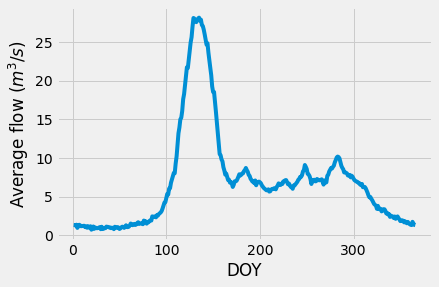

In [30]:
# Add the doy
y_data_df['doy'] = [x.timetuple().tm_yday for x in y_data_df['flow_dates']]
average_flow = y_data_df.groupby('doy')['flow'].mean()
# y_data_df = pd.merge(y_data_df, average_flow, left_on='doy', right_index=True,suffixes= ('','_doy')).sort_values(by=['flow_dates'])

#Plot the average flow along the year
plt.plot(average_flow.index ,average_flow)
plt.xlabel('DOY')
plt.ylabel('Average flow $(m{^3}/s)$')

For each y data, add the x data from the previous days

In [31]:
# Add the shifted x data
for shift_n in range(1, 11):
    data_tmp = x_data_df.copy()
    data_tmp['obs_dates'] = data_tmp['obs_dates'] + np.timedelta64(shift_n,'D')

    keep_same = {'obs_dates'}
    data_tmp.columns = ['{}{}'.format(c, '' if c in keep_same else '-'+str(shift_n)) for c in data_tmp.columns]
    data_tmp
    y_data_df = pd.merge(y_data_df, data_tmp, left_on='flow_dates', right_on='obs_dates')
    y_data_df = y_data_df.drop(['obs_dates'], axis = 1)
y_data_df

,flow,flow_dates,flow-1,doy,T1-1,T2-1,T3-1,T4-1,T5-1,T6-1,...,T9-10,P1-10,P2-10,P3-10,P4-10,P5-10,P6-10,P7-10,P8-10,P9-10
0,1.723781,1958-01-04,NaN,4,-17.5,-17.1,-18.6,-17.4,-16.9,-16.700001,...,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
1,0.960882,1958-01-05,1.723781,5,-12.8,-13.0,-13.0,-12.5,-12.5,-12.700000,...,-4.0,1.0,0.2,1.5,0.9,1.0,1.1,3.0,1.8,1.4
2,0.001000,1958-01-06,0.960882,6,-7.8,-7.9,-8.4,-7.0,-7.3,-8.600000,...,0.7,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0
3,0.001000,1958-01-07,0.001000,7,-11.0,-9.9,-6.5,-8.5,-9.0,-7.400000,...,4.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.316796,1958-01-08,0.001000,8,-13.2,-12.2,-7.9,-10.7,-11.3,-9.800000,...,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,4.876250,2015-12-28,2.177040,362,-12.5,-11.7,-8.6,-11.0,-10.9,-9.200000,...,-1.5,4.5,5.1,2.6,5.0,3.0,4.4,1.1,0.0,4.1
21148,4.998840,2015-12-29,4.876250,363,-12.5,-11.9,-9.1,-11.4,-11.2,-9.800000,...,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21149,4.428777,2015-12-30,4.998840,364,-11.9,-11.4,-8.4,-10.8,-10.8,-8.600000,...,2.8,0.0,0.0,0.1,0.0,0.0,0.9,0.0,0.0,2.3
21150,4.047925,2015-12-31,4.428777,365,-7.0,-6.5,-3.4,-5.9,-6.1,-4.800000,...,6.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1.2,0.0


In [32]:
# Identify Anomalies/ Missing Data
data_df = y_data_df.dropna()
# Descriptive statistics for each column
data_df.describe()

,flow,flow-1,doy,T1-1,T2-1,T3-1,T4-1,T5-1,T6-1,T7-1,...,T9-10,P1-10,P2-10,P3-10,P4-10,P5-10,P6-10,P7-10,P8-10,P9-10
count,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,...,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000,21151.000000
mean,6.915295,6.915289,183.324666,-0.043459,0.718595,2.985169,1.493457,1.278980,2.318637,1.894922,...,3.535781,1.991003,2.007480,2.075628,2.212789,2.265302,2.214992,2.306009,2.386152,2.256560
std,9.667508,9.667672,105.368209,8.262015,8.397211,9.049364,8.571900,8.467545,8.613350,8.575314,...,8.956011,4.027063,4.349081,4.498062,4.561671,4.758722,4.910912,4.809250,5.426259,5.186563
min,0.000031,0.000031,1.000000,-33.799999,-32.599998,-33.299999,-33.700001,-32.799999,-32.200001,-33.200001,...,-30.799999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.157065,1.157065,92.000000,-5.800000,-5.200000,-3.100000,-4.400000,-4.600000,-3.700000,-4.000000,...,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.155702,3.155095,183.000000,0.200000,0.900000,3.400000,1.800000,1.500000,2.500000,2.200000,...,3.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.597197,8.597197,275.000000,6.600000,7.600000,10.600000,8.500000,8.200000,9.500000,9.000000,...,11.100000,2.500000,2.200000,2.200000,2.600000,2.600000,2.200000,2.600000,2.200000,2.000000
max,85.397653,85.397653,366.000000,20.299999,21.200001,23.400000,21.700001,21.700001,22.700001,21.799999,...,24.000000,61.500000,60.700001,66.800003,64.000000,62.400002,61.299999,64.500000,67.699997,73.699997


## Prepare the data for the model

Convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. Save the column headers, which are the names of the features, to a list to use later

In [11]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(data_df['flow'])
# Remove the labels from the features
# axis 1 refers to the columns
features= data_df.drop(['flow', 'flow_dates', 'doy'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [22]:
# check the feature list, make sure there are not labels in it
feature_list

['flow-1',
 'T1-1',
 'T2-1',
 'T3-1',
 'T4-1',
 'T5-1',
 'T6-1',
 'T7-1',
 'T8-1',
 'T9-1',
 'P1-1',
 'P2-1',
 'P3-1',
 'P4-1',
 'P5-1',
 'P6-1',
 'P7-1',
 'P8-1',
 'P9-1',
 'T1-2',
 'T2-2',
 'T3-2',
 'T4-2',
 'T5-2',
 'T6-2',
 'T7-2',
 'T8-2',
 'T9-2',
 'P1-2',
 'P2-2',
 'P3-2',
 'P4-2',
 'P5-2',
 'P6-2',
 'P7-2',
 'P8-2',
 'P9-2',
 'T1-3',
 'T2-3',
 'T3-3',
 'T4-3',
 'T5-3',
 'T6-3',
 'T7-3',
 'T8-3',
 'T9-3',
 'P1-3',
 'P2-3',
 'P3-3',
 'P4-3',
 'P5-3',
 'P6-3',
 'P7-3',
 'P8-3',
 'P9-3',
 'T1-4',
 'T2-4',
 'T3-4',
 'T4-4',
 'T5-4',
 'T6-4',
 'T7-4',
 'T8-4',
 'T9-4',
 'P1-4',
 'P2-4',
 'P3-4',
 'P4-4',
 'P5-4',
 'P6-4',
 'P7-4',
 'P8-4',
 'P9-4',
 'T1-5',
 'T2-5',
 'T3-5',
 'T4-5',
 'T5-5',
 'T6-5',
 'T7-5',
 'T8-5',
 'T9-5',
 'P1-5',
 'P2-5',
 'P3-5',
 'P4-5',
 'P5-5',
 'P6-5',
 'P7-5',
 'P8-5',
 'P9-5',
 'T1-6',
 'T2-6',
 'T3-6',
 'T4-6',
 'T5-6',
 'T6-6',
 'T7-6',
 'T8-6',
 'T9-6',
 'P1-6',
 'P2-6',
 'P3-6',
 'P4-6',
 'P5-6',
 'P6-6',
 'P7-6',
 'P8-6',
 'P9-6',
 'T1-7',
 'T2-7',

Use Skicit-learn to split data into training and testing sets

In [13]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

Look at the shape of all the data to make sure we did everything correctly. We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels :

In [14]:
# We can 
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (15863, 181)
Training Labels Shape: (15863,)
Testing Features Shape: (5288, 181)
Testing Labels Shape: (5288,)


## Baseline prediction
The baseline prediction are the previous day flow

In [15]:
baseline_preds = test_features[:, feature_list.index('flow-1')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.35


## Train Model

In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

## Make Predictions on the Test Set

In [17]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.26


The RF model was able to improve the predictions

## Predicted vs Observed

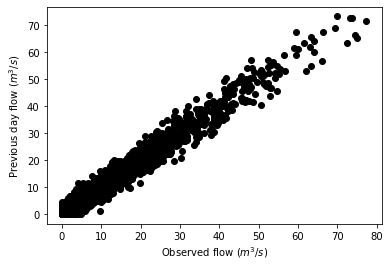

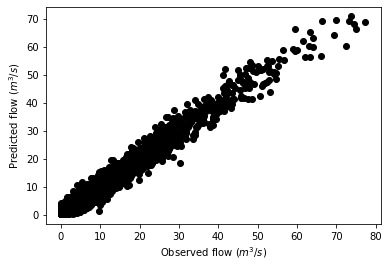

In [18]:
plt.figure()
# Print out the mean absolute error (mae)
plt.plot(test_labels, test_features[:, feature_list.index('flow-1')], 'o', color='black')
plt.xlabel('Observed flow $(m{^3}/s)$')
plt.ylabel('Previous day flow $(m{^3}/s)$')
plt.show()

plt.figure()
# Print out the mean absolute error (mae)
plt.plot(test_labels,predictions, 'o', color='black')
plt.xlabel('Observed flow $(m{^3}/s)$')
plt.ylabel('Predicted flow $(m{^3}/s)$')
plt.show()



## Variable Importances

In [33]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[0:50]];

Variable: flow-1               Importance: 0.96665
Variable: T9-4                 Importance: 0.00043
Variable: T9-5                 Importance: 0.0004
Variable: T9-9                 Importance: 0.00038
Variable: T1-9                 Importance: 0.00036
Variable: T1-10                Importance: 0.00036
Variable: T1-5                 Importance: 0.00035
Variable: T9-6                 Importance: 0.00035
Variable: T9-8                 Importance: 0.00034
Variable: T3-4                 Importance: 0.00033
Variable: T1-7                 Importance: 0.00033
Variable: T9-10                Importance: 0.00033
Variable: T9-1                 Importance: 0.00032
Variable: T1-6                 Importance: 0.00032
Variable: T9-7                 Importance: 0.00032
Variable: T1-8                 Importance: 0.00032
Variable: T9-3                 Importance: 0.00031
Variable: T9-2                 Importance: 0.00029
Variable: T3-1                 Importance: 0.00028
Variable: T1-4                 I

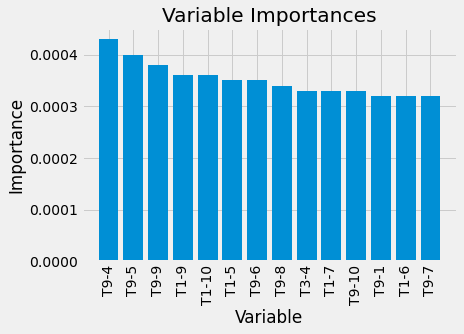

In [21]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
importances2 = [importance for feature, importance in feature_importances[1:15]]
feature_list2 = [feature for feature, importance in feature_importances[1:15]]

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances2)))
# Make a bar chart
plt.bar(x_values, importances2, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list2, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');